In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import sys
sys.path.append("..")

from dataloaders.dataloader_v1 import get_loader
import torch
from wcmatch.pathlib import Path
from utils.utils import crop_center_half, ifft2d, normalize, flip_to_minimize_loss
from utils.algorithms import get_algorithm
from matplotlib import pyplot as plt
from einops import rearrange, repeat
import cv2
import numpy as np
import random

root = "/hdd_mnt/onurcan/onurk/datasets/"
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
batch_size = 24*3
stage = "train"
dataloader = get_loader("noise_amplitude_with_robust_hio_dataset", stage, root, batch_size, alpha=3)
stage = "val"
val_dataloader = get_loader("noise_amplitude_with_robust_hio_dataset", stage, root, batch_size, alpha=3)
stage = "test"
test_dataloader = get_loader("noise_amplitude_with_robust_hio_dataset", stage, root, batch_size, alpha=3)

KeyboardInterrupt: 

In [ ]:
selected_indices_dataloader = list(range(3000)) + [random.randrange(len(dataloader.dataset)) for _ in range(57000)]
dataloader = torch.utils.data.DataLoader(torch.utils.data.Subset(dataloader.dataset, selected_indices_dataloader), batch_size=batch_size)
len(dataloader)

834

In [ ]:
import torch
from utils.utils import zero_padding_twice, fft2d, ifft2d
from utils.algorithms import apply_image_constraint_hio
from models.denoisers import get_denoiser

class End2End(torch.nn.Module):
    def __init__(
        self,
        device: torch.device,
        total_iterations: int = 12,
        total_dc_iterations: int = 5,
        denoiser_architecture: str = "FBPConvNet",
    ):
        super().__init__()

        self.denoiser = get_denoiser(denoiser_architecture)().to(device)

        self.lam = torch.nn.Parameter(
            torch.logspace(-0.15, -2.9, total_iterations).to(device)
        )  # 1....0.125 from the thesis, lam should be [0,1]
        
        self.total_iterations = total_iterations
        self.total_dc_iterations = total_dc_iterations
        self.beta = 0.9
        self.alpha = 3.0

    def forward(self, hio_output, amplitude, support, total_time_steps = None, last_iterations_to_train = 1):
        total_time_steps = total_time_steps or self.total_iterations

        assert total_time_steps <= self.total_iterations, "total_time_steps should be smaller than total_iterations"
        assert last_iterations_to_train <= total_time_steps, "last_iterations_to_train should be smaller than total_time_steps"
            
        x_ = hio_output
        
        self.denoiser.eval()
        with torch.no_grad():
            for i in range(total_time_steps - last_iterations_to_train):
                z_ = self.denoiser(x_ / 255.0, i) * 255.0
                z_ = torch.clamp(z_, min=0.0, max=255.0)
                x_ = self.dc(z_, amplitude, i, support)
                if (i == total_time_steps - 1) and (last_iterations_to_train == 0):
                    return [z_, x_]
                x_ = x_ + self.lam[i] * torch.randn_like(x_) * self.alpha * self.alpha

        self.denoiser.train()
        output_list = []
        for i in range(total_time_steps - last_iterations_to_train, total_time_steps):
            z_ = self.denoiser(x_ / 255.0, i) * 255.0
            output_list.append(z_) # normalize(x_)
            z_ = torch.clamp(z_, min=0.0, max=255.0)
            x_ = self.dc(z_, amplitude, i, support)
            output_list.append(x_) # normalize(x_)
            x_ = x_ + self.lam[i] * torch.randn_like(x_) * self.alpha * self.alpha

        return output_list

    def dc(self, z, b, i, support):
        z_k = zero_padding_twice(z)
        z_0 = z_k

        for _ in range(self.total_dc_iterations):
            Fz = fft2d(z_k)
            # x_kprime = ifft2d(torch.polar(self.lam[i] * b + (1 - self.lam[i]) * Fz.abs(), Fz.angle())).real
            x_kprime = ifft2d(torch.polar(self.lam[i] * b, Fz.angle())).real + (1 - self.lam[i]) * z_0
            z_k = apply_image_constraint_hio(x_kprime, z_k, support, beta=self.beta)

        return crop_center_half(z_k)

In [ ]:
total_iterations = 18
denoiser_architecture = "UNet2D"

end2end_model = End2End(device=device, total_iterations=total_iterations, denoiser_architecture=denoiser_architecture)
loss = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(end2end_model.parameters(), lr=5e-5, betas=(0.95, 0.999), weight_decay=1e-5)

train

In [ ]:
# end2end_model.load_state_dict(torch.load("save_mololoed_betterscheduler_clamp_morenoise_moreiterations_notzx_new_yesyesyesyesyesyes_103.pth"))
# end2end_model.load_state_dict(torch.load("save_mololoed_betterscheduler_clamp_morenoise_moreiterations_notzx_new_yesyesyesyesyesyes_allimages_35.pth"))
end2end_model.load_state_dict(torch.load("save_mololoed_betterscheduler_clamp_morenoise_moreiterations_notzx_new_yesyesyesyesyesyes_allimages_best_amax_newwithcorrectsnr.pth"))

<All keys matched successfully>

In [ ]:
import logging
logging.basicConfig(level=logging.INFO, filename="notebooks/py_log_last_epoch_cvat_mololo_3noise_normalized_betterscheduler_clamp_morenoise_moreiterations_notzx_new___yesyesyes_allimages_amax_newwithcorrectsnr_2___.log", filemode="w", format='%(asctime)s %(levelname)-8s %(message)s', datefmt='%Y-%m-%d %H:%M:%S')

continue_from_epoch = 40
N_epochs = 110
dataloader_len = len(dataloader)

from diffusers.optimization import get_scheduler
lr_scheduler = get_scheduler(
    "cosine",
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=(dataloader_len * N_epochs) //
    1,
)

min_test_loss = float("inf")

logging.info("epoch (index_dataloader/dataloader_len), loss_value.item(), epoch_losses.mean(), epoch_losses_hio.mean(), total_time_steps, total_time_steps_random_mode")
for epoch in range(continue_from_epoch, N_epochs):
    end2end_model.train()
    
    epoch_losses = np.array([])
    epoch_losses_hio = np.array([])
    
    for index_dataloader, (im, am, sp, robust_output) in enumerate(dataloader):
        im = im.to(device)
        am = am.to(device)
        sp = sp.to(device)
        robust_output = robust_output.to(device).float()
        
        total_time_steps_random_mode = min(epoch / (N_epochs * 3/4) * (total_iterations + 3) + 1, total_iterations + 3)
        total_time_steps = int(random.gauss(mu=total_time_steps_random_mode, sigma=3.5))
        total_time_steps = max(total_time_steps, 1)
        total_time_steps = min(total_time_steps, total_iterations)
        
        last_iterations_to_train = 1
        last_iterations_to_train = max(last_iterations_to_train, 1)
        last_iterations_to_train = min(last_iterations_to_train, total_time_steps)
        
        outputs = end2end_model(robust_output, am, sp, total_time_steps=total_time_steps, last_iterations_to_train=last_iterations_to_train)
        target_im = crop_center_half(im).float()
        
        # loss calculation
        final_loss = 0.0
        coefficients = torch.exp(torch.arange(len(outputs)))
        for coefficient, output in zip(coefficients, outputs):
            loss_value = loss(output, target_im)
            final_loss += coefficient * loss_value

        # print(epoch, loss_value.item(), final_loss.item(), loss(target_im, robust_output).item(), total_time_steps, total_time_steps_random_mode)
        final_loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        
        epoch_losses = np.append(epoch_losses, loss_value.item())
        epoch_losses_hio = np.append(epoch_losses_hio, loss(target_im, robust_output).item())
    
        if (index_dataloader+1) % (dataloader_len // 7) == 0:
            logging.info(f"train: {epoch} ({index_dataloader}/{dataloader_len}), {loss_value.item()}, {epoch_losses.mean()}, {epoch_losses_hio.mean()}, {total_time_steps}, {total_time_steps_random_mode}")

    end2end_model.eval()
    with torch.no_grad():
        epoch_losses_val = np.array([])
        epoch_losses_hio_val = np.array([])
        for im, am, sp, robust_output in val_dataloader:
            im = im.to(device)
            am = am.to(device)
            sp = sp.to(device)
            robust_output = robust_output.to(device).float()
            
            total_time_steps = total_iterations
            last_iterations_to_train = 1
            
            outputs = end2end_model(robust_output, am, sp, total_time_steps=total_time_steps, last_iterations_to_train=last_iterations_to_train)
            target_im = crop_center_half(im).float()
            
            # loss calculation
            final_loss = loss(outputs[-1], target_im)
            epoch_losses_val = np.append(epoch_losses_val, final_loss.item())
            epoch_losses_hio_val = np.append(epoch_losses_hio_val, loss(target_im, robust_output).item())
            
        logging.info(f"val: {epoch}, {epoch_losses_val.mean()}, {epoch_losses_hio_val.mean()}, {total_time_steps}")
        
        epoch_losses_val = np.array([])
        epoch_losses_hio_val = np.array([])
        for im, am, sp, robust_output in test_dataloader:
            im = im.to(device)
            am = am.to(device)
            sp = sp.to(device)
            robust_output = robust_output.to(device).float()
            
            total_time_steps = total_iterations
            last_iterations_to_train = 1
            
            outputs = end2end_model(robust_output, am, sp, total_time_steps=total_time_steps, last_iterations_to_train=last_iterations_to_train)
            target_im = crop_center_half(im).float()
            
            # loss calculation
            final_loss = loss(outputs[-1], target_im)
            epoch_losses_val = np.append(epoch_losses_val, final_loss.item())
            epoch_losses_hio_val = np.append(epoch_losses_hio_val, loss(target_im, robust_output).item())
            
        logging.info(f"test: {epoch}, {epoch_losses_val.mean()}, {epoch_losses_hio_val.mean()}, {total_time_steps}")
        
        if(epoch % 14 == 7):
            torch.save(end2end_model.state_dict(), f"save_mololoed_betterscheduler_clamp_morenoise_moreiterations_notzx_new_yesyesyesyesyesyes_allimages_{epoch}_amax_newwithcorrectsnr_2__.pth")
        
        if(min_test_loss > epoch_losses_val.mean()):
            min_test_loss = epoch_losses_val.mean()
            torch.save(end2end_model.state_dict(), f"save_mololoed_betterscheduler_clamp_morenoise_moreiterations_notzx_new_yesyesyesyesyesyes_allimages_best_amax_newwithcorrectsnr_2__.pth")
        
torch.save(end2end_model.state_dict(), "save_mololoed_betterscheduler_clamp_morenoise_moreiterations_notzx_new_yesyesyesyesyesyes_allimages_last_amax_newwithcorrectsnr_2__.pth")

inference

In [ ]:
end2end_model.load_state_dict(torch.load("save_mololoed_betterscheduler_clamp_morenoise_moreiterations_notzx_new_yesyesyesyesyesyes_allimages_best_amax_newwithcorrectsnr.pth"))

<All keys matched successfully>

In [ ]:
from tqdm import tqdm
import time
from utils.utils import crop_center_half, ifft2d, normalize, flip_to_minimize_loss
from utils.algorithms import get_algorithm
from torchmetrics.functional.image import structural_similarity_index_measure, peak_signal_noise_ratio
import logging
import pickle

filename = "notebooks/py_log_last_epoch_cvat_mololo_3noise_normalized_betterscheduler_clamp_morenoise_moreiterations_notzx_new___testtttyesyesyes_103_allimages_finalll___newwithcorrectsnr2_____"

In [ ]:
test_dataloader = get_loader("noise_amplitude_with_robust_hio_dataset", stage, root, batch_size=1, alpha=3)

In [ ]:
logging.basicConfig(level=logging.INFO, filename=f"{filename}.log", filemode="w", format='%(asctime)s %(levelname)-8s %(message)s', datefmt='%Y-%m-%d %H:%M:%S')

end2end_model.eval()
with torch.no_grad():
    # epoch_mean_metrics = []
    all_metrics = []

    for i_montecarlo in range(5):
        epoch_metrics = {
            # "mse_hio": np.array([]),
            # "mse_initialization": np.array([]),
            # "mse_developed": np.array([]),
            
            "psnr_hio": np.array([]),
            "psnr_initialization": np.array([]),
            "psnr_developed": np.array([]),
            
            "ssim_hio": np.array([]),
            "ssim_initialization": np.array([]),
            "ssim_developed": np.array([]),
            
            "time_hio": np.array([]),
            "time_initialization": np.array([]),
            "time_developed": np.array([]),
        }

        test_i = 0
        for im, am, sp, robust_output in tqdm(test_dataloader):
            im = im.to(device)
            am = am.to(device)
            sp = sp.to(device)
            robust_output = robust_output.to(device).float()
            
            # HIO method
            start_hio = time.time()
            
            g, _ = get_algorithm("HIO")(am, sp, use_tqdm=False, iteration=1000)
            im_cropped_normalized = normalize(crop_center_half(im)) # normalize decreases the metrics
            g_cropped_normalized = normalize(crop_center_half(g))
            all_mse_loss_corrected = flip_to_minimize_loss(g_cropped_normalized, im_cropped_normalized)
            hio_output = all_mse_loss_corrected[0] * 255
            
            end_hio = time.time()
            
            # Developed algorithm
            start_developed = time.time()
            
            g, _ = get_algorithm("RobustHIO")(am, sp, use_tqdm=False)
            
            end_initialization = time.time()
            
            im_cropped_normalized = normalize(crop_center_half(im)) # normalize decreases the metrics
            g_cropped_normalized = normalize(crop_center_half(g))
            all_mse_loss_corrected = flip_to_minimize_loss(g_cropped_normalized, im_cropped_normalized)
            robust_output = all_mse_loss_corrected[0] * 255
            robust_output = robust_output.to(device).float()

            outputs = end2end_model(robust_output, am, sp, total_time_steps=total_iterations, last_iterations_to_train=0)

            end_developed = time.time()
            
            # measure time
            epoch_metrics["time_hio"] = np.append(epoch_metrics["time_hio"], end_hio - start_hio)
            epoch_metrics["time_initialization"] = np.append(epoch_metrics["time_initialization"], end_initialization - start_developed)
            epoch_metrics["time_developed"] = np.append(epoch_metrics["time_developed"], end_developed - start_developed)
            
            # loss calculation
            target_im = crop_center_half(im).float()
            
            # normalization - makes the metrics worse!
            # target_im = normalize(target_im) * 255
            # hio_output = normalize(hio_output) * 255
            # robust_output = normalize(robust_output) * 255
            # outputs[-1] = normalize(outputs[-1]) * 255
            
            # mse_hio = loss(hio_output, target_im).item()
            # epoch_metrics["mse_hio"] = np.append(epoch_metrics["mse_hio"], mse_hio)
            # mse_initialization = loss(robust_output, target_im).item()
            # epoch_metrics["mse_initialization"] = np.append(epoch_metrics["mse_initialization"], mse_initialization)
            # mse_developed = loss(outputs[-1], target_im).item()
            # epoch_metrics["mse_developed"] = np.append(epoch_metrics["mse_developed"], mse_developed)
            
            psnr_hio = peak_signal_noise_ratio(hio_output, target_im, data_range=255, reduction="none", dim=(1,2,3)).cpu()
            epoch_metrics["psnr_hio"] = np.append(epoch_metrics["psnr_hio"], psnr_hio)
            psnr_initialization = peak_signal_noise_ratio(robust_output, target_im, data_range=255, reduction="none", dim=(1,2,3)).cpu()
            epoch_metrics["psnr_initialization"] = np.append(epoch_metrics["psnr_initialization"], psnr_initialization)
            psnr_developed = peak_signal_noise_ratio(outputs[-1], target_im, data_range=255, reduction="none", dim=(1,2,3)).cpu()
            epoch_metrics["psnr_developed"] = np.append(epoch_metrics["psnr_developed"], psnr_developed)
            
            ssim_hio = structural_similarity_index_measure(hio_output, target_im, data_range=255, reduction="none").cpu()
            epoch_metrics["ssim_hio"] = np.append(epoch_metrics["ssim_hio"], ssim_hio)
            ssim_initialization = structural_similarity_index_measure(robust_output, target_im, data_range=255, reduction="none").cpu()
            epoch_metrics["ssim_initialization"] = np.append(epoch_metrics["ssim_initialization"], ssim_initialization)
            ssim_developed = structural_similarity_index_measure(outputs[-1], target_im, data_range=255, reduction="none").cpu()
            epoch_metrics["ssim_developed"] = np.append(epoch_metrics["ssim_developed"], ssim_developed)
            
            # visualization
            # all_images = rearrange(target_im.cpu(), "b c h w -> b h w c")
            # all_robust_outputs = rearrange(robust_output.cpu(), "b c h w -> b h w c")
            # all_outputs = rearrange(outputs[-1].detach().cpu(), "b c h w -> b h w c")

            # for plt_output, plt_robust_output, plt_image in zip(all_outputs, all_robust_outputs, all_images):
            #     plt.subplot(1,4,1), plt.imshow(plt_output, cmap="gray"), plt.title("Developed"), plt.axis('off')
            #     plt.subplot(1,4,2), plt.imshow(plt_robust_output, cmap="gray"), plt.title("HIO Stage"), plt.axis('off')
            #     plt.subplot(1,4,3), plt.imshow(plt_image, cmap="gray"), plt.title("GT"), plt.axis('off')
            #     plt.subplot(1,4,4), plt.imshow((plt_output - plt_image).abs(), cmap="gray"), plt.title("Difference"), plt.axis('off')
            #     plt.savefig(f"/hdd_mnt/onurcan/onurk/notebooks/example_test_results_final/{test_i}_{i_montecarlo}.png", bbox_inches='tight', dpi=300)
            #     test_i += 1
            
        epoch_metrics_mean = {k: v.mean() for k, v in epoch_metrics.items()}
        all_metrics.append(epoch_metrics)
        # epoch_mean_metrics.append(epoch_metrics_mean)
        logging.info(epoch_metrics_mean)
        
    logging.info("Evaluation finished")
    
    # save all_metrics
    with open(f"{filename}.pkl", "wb") as f:
        pickle.dump(all_metrics, f)
    
    # epoch_mean_metrics = {k: np.array([v[k] for v in epoch_mean_metrics]).mean() for k in epoch_mean_metrics[0].keys()}
    # logging.info(epoch_mean_metrics)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 236/236 [05:12<00:00,  1.32s/it]


compute statistics

In [ ]:
# read pickle
all_metrics = pickle.load(open(f"{filename}.pkl", "rb"))

In [ ]:
all_image_indices = np.arange(len(all_metrics[0]['psnr_hio']))
unnatural_images_slice = np.arange(114, 120)
natural_images_slice = np.setdiff1d(all_image_indices, unnatural_images_slice)

In [ ]:
for i in range(len(all_metrics)):
    print("PSNR")
    print("overall", "natural", "unnatural")
    print(all_metrics[i]['psnr_hio'].mean(), all_metrics[i]['psnr_hio'][natural_images_slice].mean(), all_metrics[i]['psnr_hio'][unnatural_images_slice].mean())
    print(all_metrics[i]['psnr_initialization'].mean(), all_metrics[i]['psnr_initialization'][natural_images_slice].mean(), all_metrics[i]['psnr_initialization'][unnatural_images_slice].mean())
    print(all_metrics[i]['psnr_developed'].mean(), all_metrics[i]['psnr_developed'][natural_images_slice].mean(), all_metrics[i]['psnr_developed'][unnatural_images_slice].mean())
    
    print("")
    
    print("SSIM")
    print("overall", "natural", "unnatural")
    print(all_metrics[i]['ssim_hio'].mean(), all_metrics[i]['ssim_hio'][natural_images_slice].mean(), all_metrics[i]['ssim_hio'][unnatural_images_slice].mean())
    print(all_metrics[i]['ssim_initialization'].mean(), all_metrics[i]['ssim_initialization'][natural_images_slice].mean(), all_metrics[i]['ssim_initialization'][unnatural_images_slice].mean())
    print(all_metrics[i]['ssim_developed'].mean(), all_metrics[i]['ssim_developed'][natural_images_slice].mean(), all_metrics[i]['ssim_developed'][unnatural_images_slice].mean())
        
    print("")
    
    print("TIME")
    print("overall")
    print(all_metrics[i]['time_hio'].mean())
    print(all_metrics[i]['time_initialization'].mean())
    print(all_metrics[i]['time_developed'].mean())
    
    print("=====================================")

PSNR
overall natural unnatural
18.99314627000841 18.963657171829887 20.12356170018514
19.843683913602668 19.810118061563244 21.130374908447266
28.151695663646116 28.211549999402916 25.857279459635418

SSIM
overall natural unnatural
0.4374884670379303 0.4377318515077881 0.428158729026715
0.4575193630910273 0.45825067823347837 0.4294856159637372
0.8037442937493324 0.8064820362173992 0.6987974991401037

TIME
overall
0.27452447555832943
0.47878245074870224
1.0417056497880968
PSNR
overall natural unnatural
18.89637580160367 18.859870487710705 20.295746167500813
19.744287038253525 19.695434184696364 21.616979757944744
28.160771345688126 28.218559903683868 25.94554328918457

SSIM
overall natural unnatural
0.4329127765781546 0.43307884257772694 0.4265469132612149
0.45751507452420764 0.45770542012608567 0.4502184931188822
0.8070693731434264 0.80979274187399 0.7026735718051592

TIME
overall
0.27157968282699585
0.47777490797689404
1.0147307909141152
PSNR
overall natural unnatural
19.0462287805848

In [ ]:
print("PSNR")
print("overall", "natural", "unnatural")
print("HIO", np.array([v['psnr_hio'].mean() for v in all_metrics]).mean(), np.array([v['psnr_hio'][natural_images_slice].mean() for v in all_metrics]).mean(), np.array([v['psnr_hio'][unnatural_images_slice].mean() for v in all_metrics]).mean())
print("Initialization", np.array([v['psnr_initialization'].mean() for v in all_metrics]).mean(), np.array([v['psnr_initialization'][natural_images_slice].mean() for v in all_metrics]).mean(), np.array([v['psnr_initialization'][unnatural_images_slice].mean() for v in all_metrics]).mean())
print("Developed", np.array([v['psnr_developed'].mean() for v in all_metrics]).mean(), np.array([v['psnr_developed'][natural_images_slice].mean() for v in all_metrics]).mean(), np.array([v['psnr_developed'][unnatural_images_slice].mean() for v in all_metrics]).mean())

print("")
print("SSIM")
print("overall", "natural", "unnatural")
print("HIO", np.array([v['ssim_hio'].mean() for v in all_metrics]).mean(), np.array([v['ssim_hio'][natural_images_slice].mean() for v in all_metrics]).mean(), np.array([v['ssim_hio'][unnatural_images_slice].mean() for v in all_metrics]).mean())
print("Initialization", np.array([v['ssim_initialization'].mean() for v in all_metrics]).mean(), np.array([v['ssim_initialization'][natural_images_slice].mean() for v in all_metrics]).mean(), np.array([v['ssim_initialization'][unnatural_images_slice].mean() for v in all_metrics]).mean())
print("Developed", np.array([v['ssim_developed'].mean() for v in all_metrics]).mean(), np.array([v['ssim_developed'][natural_images_slice].mean() for v in all_metrics]).mean(), np.array([v['ssim_developed'][unnatural_images_slice].mean() for v in all_metrics]).mean())

print("")
print("TIME")
print("overall")
print("HIO", np.array([v['time_hio'].mean() for v in all_metrics]).mean())
print("Initialization", np.array([v['time_initialization'].mean() for v in all_metrics]).mean())
print("Developed", np.array([v['time_developed'].mean() for v in all_metrics]).mean())

PSNR
overall natural unnatural
HIO 19.008445471828267 18.970011291089264 20.48175573348999
Initialization 19.757213944095678 19.72407289090364 21.02762098312378
Developed 28.056251993825878 28.131319927547292 25.178647867838542

SSIM
overall natural unnatural
HIO 0.4355432557794502 0.43567113928172896 0.43064105485876397
Initialization 0.45620079845253186 0.45662608610547106 0.4398981050898631
Developed 0.8030276203243915 0.8060520553329716 0.6870909449954827

TIME
overall
HIO 0.27252600031383967
Initialization 0.47796288425639516
Developed 1.0204314510701067


graphs

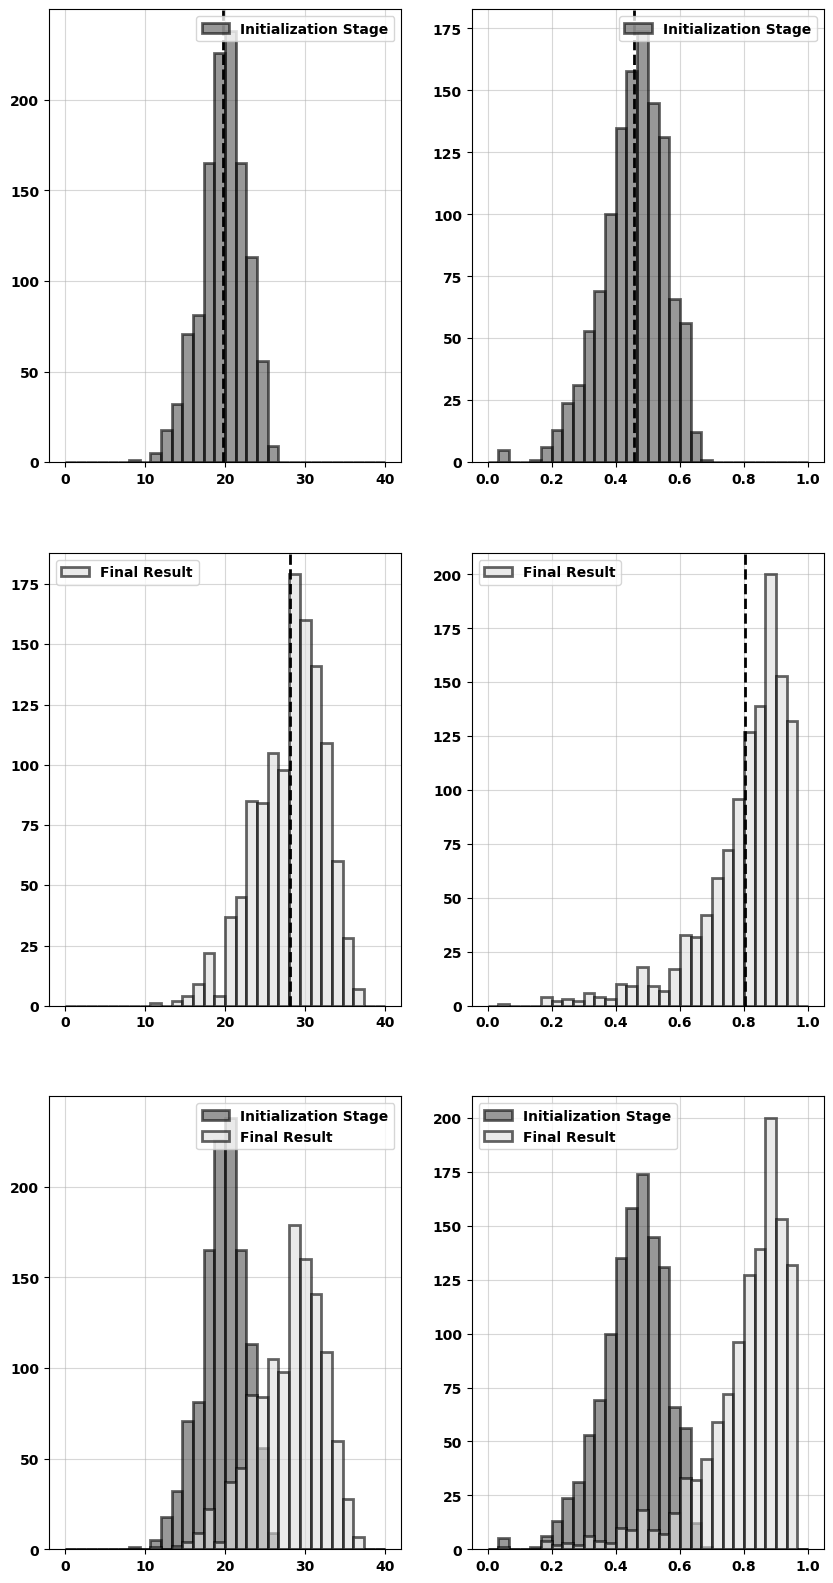

	 	 SSIM 	 || PSNR 	 || time (s)
Initialization Stage: 	 0.4562  || 19.7572 	 || 0.4780
Final Result: 	 0.8030  || 28.0563 	 || 1.0204


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

psnr_hio       = np.array(np.concatenate([metrics['psnr_initialization'] for metrics in all_metrics]))
ssim_hio       = np.array(np.concatenate([metrics['ssim_initialization'] for metrics in all_metrics]))
psnr_final     = np.array(np.concatenate([metrics['psnr_developed'] for metrics in all_metrics]))
ssim_final     = np.array(np.concatenate([metrics['ssim_developed'] for metrics in all_metrics]))
t_hio          = np.array(np.concatenate([metrics['time_initialization'] for metrics in all_metrics]))
t_final        = np.array(np.concatenate([metrics['time_developed'] for metrics in all_metrics]))

plt.figure(figsize=[10,20])

plt.rcParams.update({'font.weight': 'bold'})
alpha = .6
linewidth = 2
linewidth_mean = 2
bins_psnr = 30
bins_ssim = 30

plt1 = plt.subplot(3,2,1)
plt1.set_axisbelow(True)
plt.grid(alpha=0.5)
plt.hist(psnr_hio, bins=bins_psnr, range=(0,40), color='#545454', alpha=alpha, linewidth=linewidth, edgecolor='black')
plt.legend(['Initialization Stage'])
plt.axvline(psnr_hio.mean(), color='k', linestyle='dashed', linewidth=linewidth_mean)

plt1 = plt.subplot(3,2,2)
plt1.set_axisbelow(True)
plt.grid(alpha=0.5)
plt.hist(ssim_hio, bins=bins_ssim, range=(0,1), color='#545454', alpha=alpha, linewidth=linewidth, edgecolor='black')
plt.legend(['Initialization Stage'])
plt.axvline(ssim_hio.mean(), color='k', linestyle='dashed', linewidth=linewidth_mean)

plt1 = plt.subplot(3,2,3)
plt1.set_axisbelow(True)
plt.grid(alpha=0.5)
plt.hist(psnr_final, bins=bins_psnr, range=(0,40), color='#dddddd', alpha=alpha, linewidth=linewidth, edgecolor='black')
plt.legend(['Final Result'])
plt.axvline(psnr_final.mean(), color='k', linestyle='dashed', linewidth=linewidth_mean)

plt1 = plt.subplot(3,2,4)
plt1.set_axisbelow(True)
plt.grid(alpha=0.5)
plt.hist(ssim_final, bins=bins_ssim, range=(0,1), color='#dddddd', alpha=alpha, linewidth=linewidth, edgecolor='black')
plt.legend(['Final Result'])
plt.axvline(ssim_final.mean(), color='k', linestyle='dashed', linewidth=linewidth_mean)

# all
plt1 = plt.subplot(3,2,5)
plt1.set_axisbelow(True)
plt.grid(alpha=0.5)
plt.hist(psnr_hio, bins=bins_psnr, range=(0,40), color='#545454', alpha=alpha, linewidth=linewidth, edgecolor='black')
plt.hist(psnr_final, bins=bins_psnr, range=(0,40), color='#dddddd', alpha=alpha, linewidth=linewidth, edgecolor='black')
plt.legend(['Initialization Stage','Final Result'])

plt1 = plt.subplot(3,2,6)
plt1.set_axisbelow(True)
plt.grid(alpha=0.5)
plt.hist(ssim_hio, bins=bins_ssim, range=(0,1), color='#545454', alpha=alpha, linewidth=linewidth, edgecolor='black')
plt.hist(ssim_final, bins=bins_ssim, range=(0,1), color='#dddddd', alpha=alpha, linewidth=linewidth, edgecolor='black')
plt.legend(['Initialization Stage','Final Result'])

# save figure as eps
plt.savefig('histogram_alpha3.pdf', format='pdf', dpi=1000)

plt.show()

print('\t \t SSIM \t || PSNR \t || time (s)')
print(f'Initialization Stage: \t {ssim_hio.mean():.4f}  || {psnr_hio.mean():.4f} \t || {t_hio.mean():.4f}')
print(f'Final Result: \t {ssim_final.mean():.4f}  || {psnr_final.mean():.4f} \t || {t_final.mean():.4f}')

prepare dataset for adversarial training

In [ ]:
from tqdm import tqdm
import time
from utils.utils import crop_center_half, ifft2d, normalize, flip_to_minimize_loss
from utils.algorithms import get_algorithm

end2end_model.eval()
with torch.no_grad():
    test_i = 0
    for im, am, sp, robust_output in tqdm(val_dataloader):
        im = im.to(device)
        am = am.to(device)
        sp = sp.to(device)
        robust_output = robust_output.to(device).float()
        
        # Developed algorithm        
        g, _ = get_algorithm("RobustHIO")(am, sp, use_tqdm=False)
        im_cropped_normalized = normalize(crop_center_half(im)) # normalize decreases the metrics
        g_cropped_normalized = normalize(crop_center_half(g))
        all_mse_loss_corrected = flip_to_minimize_loss(g_cropped_normalized, im_cropped_normalized)
        robust_output = all_mse_loss_corrected[0] * 255
        robust_output = robust_output.to(device).float()

        outputs = end2end_model(robust_output, am, sp, total_time_steps=total_iterations, last_iterations_to_train=0)
        #
        target_im = crop_center_half(im).float()
        
        all_images = rearrange(target_im.cpu(), "b c h w -> b h w c")
        all_robust_outputs = rearrange(robust_output.cpu(), "b c h w -> b h w c")
        all_outputs = rearrange(outputs[-1].detach().cpu(), "b c h w -> b h w c")
        
        for plt_output, plt_robust_output, plt_image in zip(all_outputs, all_robust_outputs, all_images):
            cv2.imwrite(f"/hdd_mnt/onurcan/onurk/datasets/adversarial_alpha_3/val/output/{test_i}.png", plt_output.numpy())
            cv2.imwrite(f"/hdd_mnt/onurcan/onurk/datasets/adversarial_alpha_3/val/robust_hio/{test_i}.png", plt_robust_output.numpy())
            cv2.imwrite(f"/hdd_mnt/onurcan/onurk/datasets/adversarial_alpha_3/val/gt/{test_i}.png", plt_image.numpy())
            test_i += 1

        # break

adversarial training

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import sys
sys.path.append("..")

from dataloaders.dataloader_v1 import get_loader
import torch
from wcmatch.pathlib import Path
from utils.utils import crop_center_half, ifft2d, normalize, flip_to_minimize_loss
from utils.algorithms import get_algorithm
from matplotlib import pyplot as plt
from einops import rearrange, repeat
import cv2
import numpy as np
import random

from models.denoisers import get_denoiser

In [2]:
root = "/hdd_mnt/onurcan/onurk/datasets/adversarial_alpha_3"
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
batch_size = 13
stage = "train"
dataloader = get_loader("adversarial_dataset", stage, root, batch_size)
stage = "val"
val_dataloader = get_loader("adversarial_dataset", stage, root, batch_size)
stage = "test"
test_dataloader = get_loader("adversarial_dataset", stage, root, batch_size)

In [ ]:
adversarial_denoiser = get_denoiser("UNet2DAdv")().to(device)
loss = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(adversarial_denoiser.parameters(), lr=3e-4, betas=(0.95, 0.999), weight_decay=1e-5)

In [ ]:
# train loop
import logging
logging.basicConfig(level=logging.INFO, filename="notebooks/py_log_adversarial_alpha_3.log", filemode="w", format='%(asctime)s %(levelname)-8s %(message)s', datefmt='%Y-%m-%d %H:%M:%S')

continue_from_epoch = 0
N_epochs = 10
dataloader_len = len(dataloader)

from diffusers.optimization import get_scheduler
lr_scheduler = get_scheduler(
    "cosine",
    optimizer=optimizer,
    num_warmup_steps=300,
    num_training_steps=(dataloader_len * N_epochs) //
    1,
)

min_test_loss = float("inf")

logging.info("epoch (index_dataloader/dataloader_len), loss_value.item(), epoch_losses.mean()")
for epoch in range(continue_from_epoch, N_epochs):
    adversarial_denoiser.train()
    
    epoch_losses = np.array([])
    
    for index_dataloader, (target_im, robust_output, output) in enumerate(dataloader):
        target_im = target_im.to(device).float()
        robust_output = robust_output.to(device).float()
        output = output.to(device).float()
        
        denoised_output = adversarial_denoiser(output / 255.0, 0) * 255.0
        
        # loss calculation
        loss_value = loss(denoised_output, target_im)
        
        loss_value.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        
        epoch_losses = np.append(epoch_losses, loss_value.item())
        
        if (index_dataloader+1) % (dataloader_len // 200) == 0:
            logging.info(f"train: {epoch} ({index_dataloader}/{dataloader_len}), {loss_value.item()}, {epoch_losses.mean()}")
    
    adversarial_denoiser.eval()
    with torch.no_grad():
        epoch_losses_val = np.array([])
        epoch_losses_old_val = np.array([])
        for target_im, robust_output, output in val_dataloader:
            target_im = target_im.to(device).float()
            robust_output = robust_output.to(device).float()
            output = output.to(device).float()

            denoised_output = adversarial_denoiser(output / 255.0, 0) * 255.0

            # loss calculation
            loss_value = loss(denoised_output, target_im)
            epoch_losses_val = np.append(epoch_losses_val, loss_value.item())
            loss_value_old = loss(output, target_im)
            epoch_losses_old_val = np.append(epoch_losses_old_val, loss_value_old.item())

        logging.info(f"val: {epoch}, {epoch_losses_val.mean()}, {epoch_losses_old_val.mean()}")
        
        epoch_losses_val = np.array([])
        epoch_losses_old_val = np.array([])
        for target_im, robust_output, output in test_dataloader:
            target_im = target_im.to(device).float()
            robust_output = robust_output.to(device).float()
            output = output.to(device).float()

            denoised_output = adversarial_denoiser(output / 255.0, 0) * 255.0

            # loss calculation
            loss_value = loss(denoised_output, target_im)
            epoch_losses_val = np.append(epoch_losses_val, loss_value.item())
            loss_value_old = loss(output, target_im)
            epoch_losses_old_val = np.append(epoch_losses_old_val, loss_value_old.item())
        
        logging.info(f"test: {epoch}, {epoch_losses_val.mean()}, {epoch_losses_old_val.mean()}")
        
        if(epoch % 14 == 7):
            torch.save(adversarial_denoiser.state_dict(), f"save_adversarial_alpha_3_{epoch}.pth")
        
        # save the best model
        if(min_test_loss > epoch_losses_val.mean()):
            min_test_loss = epoch_losses_val.mean()
            torch.save(adversarial_denoiser.state_dict(), "save_adversarial_alpha_3_best.pth")
            
torch.save(adversarial_denoiser.state_dict(), "save_adversarial_alpha_3_last.pth")